In [1]:
import torch
import timm
import openslide

from torchvision import transforms
from huggingface_hub import login, snapshot_download

import matplotlib.pyplot as plt

In [2]:
print(timm.__version__)

1.0.22


In [3]:
# Determine the device to run the model on (GPU or CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
# Read the huggingface token from a file
with open("huggingface_token.key", "r") as f:
    token = f.read()

# Login to huggingface hub with the token
login(token)

In [6]:
# Download the model from huggingface hub
snapshot_download(repo_id="bioptimus/H-optimus-0", local_dir=".", local_dir_use_symlinks=False, token=token)

/home/vscode/.local/lib/python3.11/site-packages/huggingface_hub/utils/_validators.py:202: UserWarning: The `local_dir_use_symlinks` argument is deprecated and ignored in `snapshot_download`. Downloading to a local directory does not use symlinks anymore.
  warnings.warn(


Fetching 7 files:   0%|          | 0/7 [00:00<?, ?it/s]

'/workspaces/WSI-Classification'

In [8]:
# Create the model
model = timm.create_model("hf-hub:bioptimus/H-optimus-0", cache_dir="/workspaces/WSI-Classification/", pretrained=True, init_values=1e-5, dynamic_img_size=False)
# model = torch.load("H-Optimus-0.pth", map_location=device, weights_only=False)

# Put the model on the device
model = model.to(device)

# Set the model to evaluation mode
model.eval()

config.json:   0%|          | 0.00/447 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 1536, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((1536,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=1536, out_features=4608, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (norm): Identity()
        (proj): Linear(in_features=1536, out_features=1536, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((1536,), eps=1e-06, elementwise_affine=True)
      (mlp): GluMlp(
        (fc1): Linear(in_features=1536, out_features=8192, bias=True)
        (act): SiLU()
        (drop1): Dropout(p=0.0, inplace=False)
    

In [9]:
# Save the whole model
torch.save(model, "H-Optimus-0.pth")

In [5]:
# Load the whole model
model = torch.load("H-Optimus-0.pth", map_location=device, weights_only=False)

In [6]:
# Create the transform function as specified in the model huggingface config
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=(0.707223, 0.578729, 0.703617), 
        std=(0.211883, 0.230117, 0.177517)
    ),
])
transform

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=(0.707223, 0.578729, 0.703617), std=(0.211883, 0.230117, 0.177517))
)

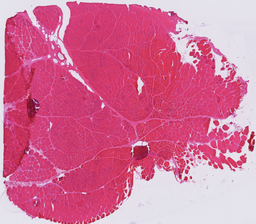

In [7]:
# Determine the slide id
slide = "tissue_crop_4352_30208"

# Load the slide with openslide
slide = openslide.OpenSlide(f"/workspaces/WSI-Classification/data/HE-MYO/Processed/Dystrophic/{slide}.ome.tiff")

# Make a thumbnail of the slide
slide.get_thumbnail(size=(256, 256))

In [14]:
# Read a 426*426 tile image of the slide
tile = slide.read_region(location=(2000, 2000), level=0, size=(426, 426))

# Convert to RGB
tile = tile.convert("RGB")

# Transform the image to the model suitable input tensor
image = transform(tile).unsqueeze(dim=0).to(device)

# Extracted features (torch.Tensor) with shape [1,1536]
with torch.inference_mode():
    feature_emb = model(image) 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.3786006..1.3262616].


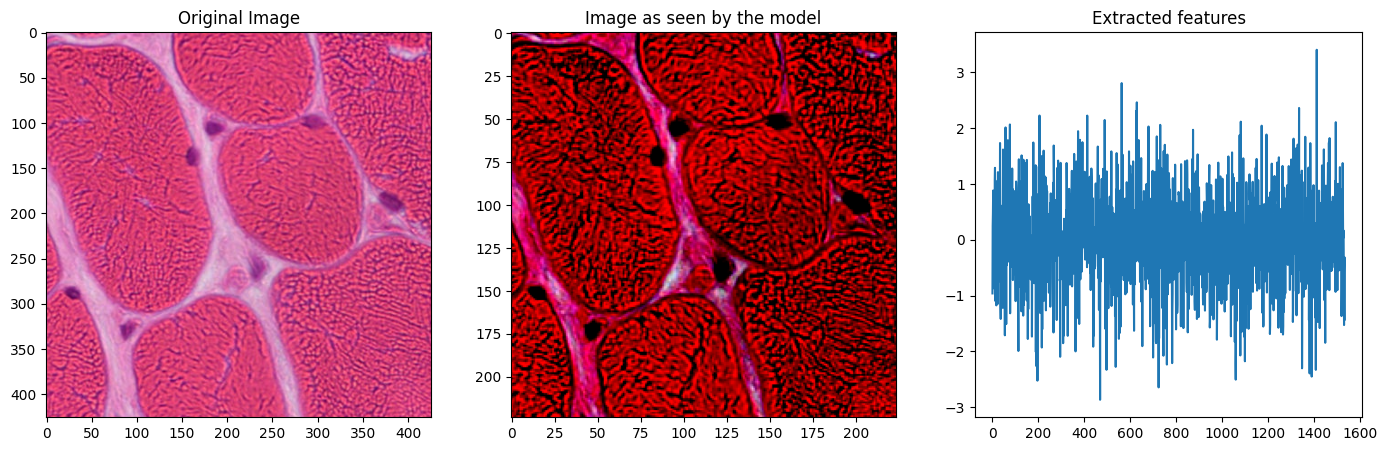

In [15]:
# Plot both the original image and the image seen by the model
fig, ax = plt.subplots(1, 3, figsize=(17, 5))

ax[0].imshow(tile)
ax[0].set_title("Original Image")

ax[1].imshow(image.cpu().squeeze().permute(1, 2, 0))
ax[1].set_title("Image as seen by the model")

ax[2].plot(feature_emb.cpu().squeeze().detach().numpy())
ax[2].set_title("Extracted features")

plt.show()